Type your name here and any comment useful for the evaluation of your work

Jakub Kwaśniak

Mehmet Emre Durmus

Jakub Domański

# Partial Differential Equation Training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 1 Linear Convection

The 1-D Linear Convection equation is the simplest, most basic model for PDEs. Here it is:
$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}=0$.
$c$ is a velocity, whereas $u$ can be any advected quantity. For example it can be the concentration of some polutant in a river flowing at speed $c$.


With given initial conditions (understood as a wave), the equation represents the propagation of that initial wave with speed $c$ along the $X$ axis, without change of shape. Let the initial condition be $u(x,0)=u_0(x)$. Then the exact solution of the equation is $u(x,t)=u_0(x−ct)$

(See lecture this morning).


We discretize this equation in both space and time, using the Forward Difference scheme for the time derivative and the Backward Difference scheme for the space derivative. Consider discretizing the spatial coordinate $x$ into points that we index from $i=0$ to $N$, and stepping in discrete time intervals of size $dt$.

We use the following convention : $U^{n}_i$ is the amplitude of the wave at time $t=n \times dt$, and at $x=i \times dx$

How woud you approximate $\frac{\partial u}{\partial t}$ , using $U^{n}_i$, with a forward difference scheme ?

Using a forward difference scheme for the temporal derivative, we write

$$ \frac{\partial U_i^n}{\partial t} \approx \frac{U_{i}^{n+1} - U_{i}^n}{dt}.$$

How woud you approximate $\frac{\partial u}{\partial x}$ , using $U^{n}_i$, with a backward difference scheme ?


Using a backward difference scheme for the spatial derivative, we write

$$\frac{\partial U_i^{n}}{\partial x} = \frac{U_{i}^n - U_{i-1}^n}{dx}$$

Write the first order explicit integration scheme we will use, in function of $U^{n}_i$, c, dt, dx, $U^{n}_i$ and $U^{n}_{i-1}$

Starting from the partial differential equation describing the advection
$$ \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0,$$
substituting the difference schemes for the derivatives
$$\frac{U_{i}^{n+1} - U_{i}^n}{dt} + c \frac{\partial U_i^{n}}{\partial x} = \frac{U_{i}^n - U_{i-1}^n}{dx} = 0.$$
Rearranging for $U_{n+1}^i$
$$U^{n+1}_i = U_{i}^{n} - \left(\frac{c dt}{dx}\right)(U_{i}^n - U_{i-1}^{n}).$$
We will let $\sigma \equiv \frac{cdt}{dx}$, being the Courant number, relevant to the CFL (Courant-Friedrichs-Lewy condition),
$$U^{n+1}_i = U_{i}^{n} - \sigma(U_{i}^n - U_{i-1}^{n}).$$

Now let's try implementing this in Python.

We want to define an evenly spaced grid of points within a  domain that is 2 units of length wide, i.e., $0<x_i<2$. Vafiable $nx$ which will be the number of grid points we want and dx will be the distance between two adjacent grid points. we define the following values 

In [2]:
nx = 41  # Number of grid points/This will be changed latter
dx = 2 / (nx-1) # Spatial step
nt = 25    # Number of timesteps dt we want to calculate
Delta_T = 0.625 # Time of integration
dt = Delta_T/(nt*1.0) # Length of each time step 
c = 1      # Assume advection velocity is c = 1

We also need to set up our initial conditions. The initial concentration $u0$
 is given as $u=2$ in the interval $0.5≤x≤1$ and $u=1$
 everywhere else in $(0,2)$  (i.e., a hat function). Build U

In [3]:
# Construct the initial concentration profile based on the boundary conditions

# Heaviside step function
step = lambda x: 2 if 0.5 <= x and 1 >= x else 1

x = np.arange(0, 2+dx, dx)
U = np.array([step(i) for i in x])

Plot, $U$, your initial concentration profile.

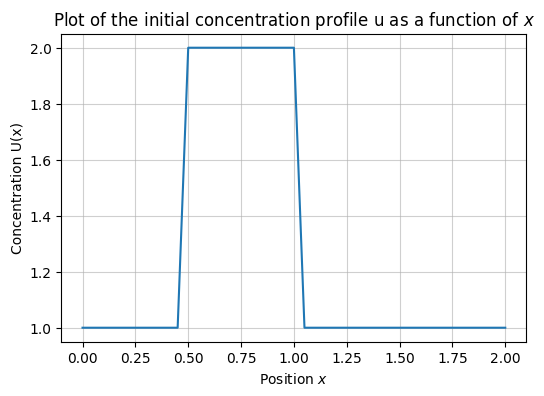

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(x, U)
plt.title(r"Plot of the initial concentration profile u as a function of $x$")
plt.xlabel(r"Position $x$")
plt.ylabel("Concentration U(x)")
plt.grid(alpha=0.6)
plt.show()

Why doesn't the hat function have perfectly straight sides? Think for a bit.

Because we have a finite $\text{d}x$, hence the linear interpolation between the last point outside of the $[0.5, 1]$ and the first point inside that interval will have a non-infinite slope.

Now we implement the discretization of the convection equation using a finite-difference scheme. For every element i of our array $U^{n}_i$ we need to perform the operation define above ($U^{n+1}_i$).  We'll store the result in a new (temporary) array $Un$, which will be the next state of $U$ for the next time-step. We will repeat this operation for as many time-steps as we specify and then we can see how far the concentration profile has convected.

We will need also boundary conditions, so for the moment we will only use periodic boundary conditions (what leaves from the right, re-enters at the left)

 The code's structure is the following :
 
 1) define U at time =0, dt, dx, c etc...
 
 2) compute Un as a function of U and all other information.
 
 3) Take care of boundary conditions at the edges  (use periodic boundary conditions on X)
 
 4) Time=Time+dt
 
 5) go back to 2
 

Boundary conditions: Explain how you compute the first and last point of the grid (i=0 and i=N)

Due to imposing the periodic boundary conditions on space $X$, the edge points are equal, i.e $i=0$ is the same as $i=N$, i.e. $U^n_{i=N} = U^n_{i=0}$. This is set by the initial concentration profile $u(x,0)$, which determines the actual profile of the solution.

Write the code...

In [5]:
def finite_difference(U: np.ndarray, dt: float, dx: float, c:float, nx: int, nt: int) -> np.ndarray:
    """Funciton implementing the finite difference method to solve the advection equation (using the upwind scheme).
    
    Params:
    U (np.ndarray): array of the initial profile u(x,0)
    dt (float): time step
    dx (float): spatial step
    c (float): speed of the wave
    nx (int): number of spatial grid points
    nt (int): number of temporal grid points
    
    Returns:
    T (np.ndarray): array of function profiles u(x) for given times ranging from 0 to nt * dt
    sigma (float): Courant number
    """
    # Calculate the sigma
    sigma = c * dt/dx
    
    # Start with time t=0
    U_n = U.copy()

    # Construct an array of available times for which the profile will be evaluated
    T = np.zeros((nt+1, nx)) # Include t=0
    # Set initial condition
    T[0] = U_n
    
    # Evolve in time: evaluate U_n at time t+dt
    # Iterate over time points
    for n in range(1, nt+1):
        # Iterate over space points
        for i in range(1, nx):
            T[n, i] = T[n-1, i] - sigma*(T[n-1, i] - T[n-1, i-1])
        # Periodic boundary conditon
        T[n,0] = T[n,-1]

    return T, sigma

Plot U at different times: 3 time steps, 12 time steps, 25 time steps

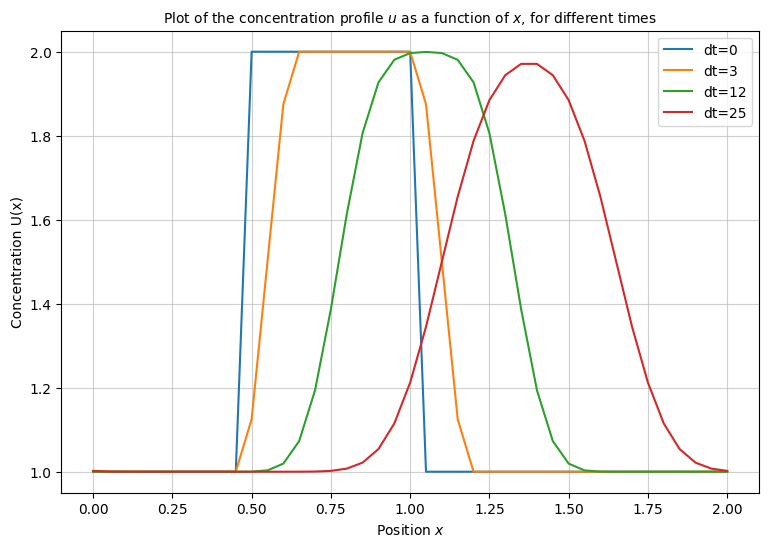

In [6]:
T, sigma = finite_difference(U, dt, dx, c, nx, nt)

fig, ax = plt.subplots(figsize=(9,6))
plt.title(r"Plot of the concentration profile $u$ as a function of $x$, for different times", fontsize=10)
plt.xlabel(r"Position $x$")
plt.ylabel("Concentration U(x)")

for DT in [0, 3, 12, 25]:
    plt.plot(x, T[DT], label=f"dt={DT}")

plt.legend()
plt.grid(alpha=0.6)

What do you notice ? comment on what you see.

The concentration profile is a wave propagating to the right, as time progresses. When the system is allowed some time to develop, the concentration will smooth out from the initial top-hat function into one resembling a Gaussian profile. For larger times, this curve is smoothed out. We do not expect this from the analytical solution of the advectin equation, as the solution is just a popagating wave - the initial signal will only tanslate to the right.

What is the value of CFL=dt C / dx ? 

In [7]:
print(f"The value of the Courant number: {sigma}")

The value of the Courant number: 0.5


Redo the same computation, varying dt , for CFL>1. and CFL << 1

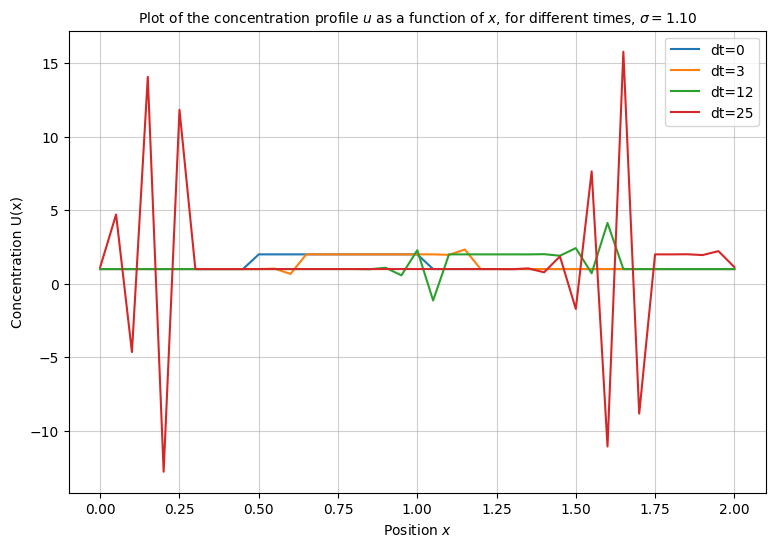

In [8]:
# [CFL > 1] Change the time step dt to obtain CFL > 1 -> Increase dt
dt = 0.055 # Length of each time step 

# Compute and plot the solution for different times
T, sigma = finite_difference(U, dt, dx, c, nx, nt)

fig, ax = plt.subplots(figsize=(9,6))
plt.title(r"Plot of the concentration profile $u$ as a function of $x$, for different times, $\sigma={:.2f}$".format(sigma), fontsize=10)
plt.xlabel(r"Position $x$")
plt.ylabel("Concentration U(x)")

for DT in [0, 3, 12, 25]:
    plt.plot(x, T[DT], label=f"dt={DT}")

plt.legend()
plt.grid(alpha=0.6)

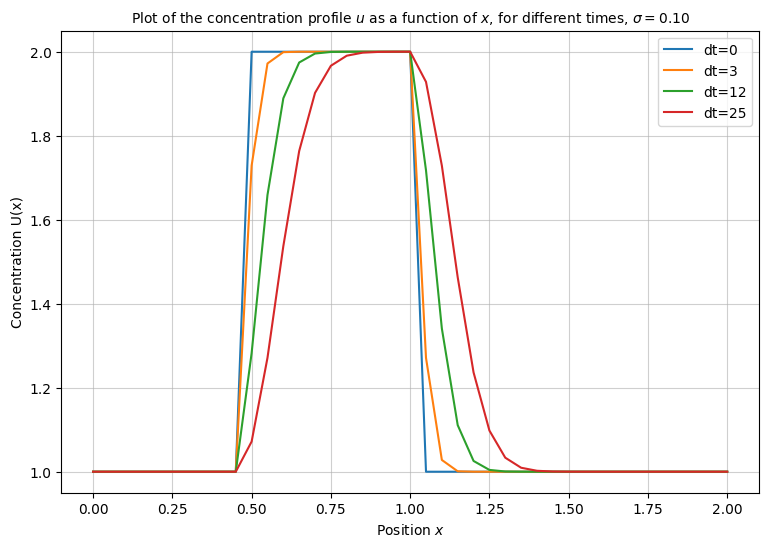

In [9]:
# [CFL < 1] Change the time step dt to obtain CFL > 1 -> Decrease dt
dt = 0.005 # Length of each time step 

# Compute and plot the solution for different times
T, sigma = finite_difference(U, dt, dx, c, nx, nt)

fig, ax = plt.subplots(figsize=(9,6))
plt.title(r"Plot of the concentration profile $u$ as a function of $x$, for different times, $\sigma={:.2f}$".format(sigma), fontsize=10)
plt.xlabel(r"Position $x$")
plt.ylabel("Concentration U(x)")

for DT in [0, 3, 12, 25]:
    plt.plot(x, T[DT], label=f"dt={DT}")

plt.legend()
plt.grid(alpha=0.6)

What do you notice ? What is the the good integration conditions ?

For values of CFL larger than one, we notice a large deviation from the expected behaviour, making the entire solution unstable and unphysical. However, on the other hand, for CFL < 1, the function profile resembles the initial Heaviside-form more, which means it is more stable. In general, based on the CFL condition, in order to ensure the stability of the solution, the time step needs to be much shorter than the time needed to propagate the profile by $dx$. This translates to $\sigma \leq 1$. However, this requires more points to be computed for the same time period, and hence requires more computational resources.  

Now redo the computation, with CFL>1 and using an initial U that is gaussian.

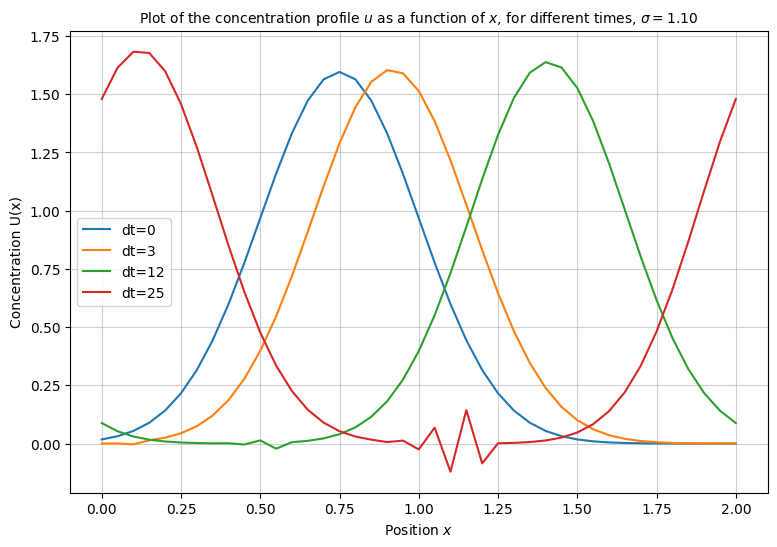

In [10]:
# Use a Gaussian profile on the range of x in [0,2]
gauss = lambda x, mu, s: 1/np.sqrt(2*np.pi*s*s) * np.exp(-(x-mu)*(x-mu)/(2*s*s))

U = np.array([gauss(i, 0.75, 0.25) for i in x]) # mu=0.75, s=0.25 so that the edges of the original tophat are one standard deviation away from its center

# [CFL > 1] Change the time step dt to obtain CFL > 1 -> Increase dt
dt = 0.055 # Length of each time step 

# Compute and plot the solution for different times
T, sigma = finite_difference(U, dt, dx, c, nx, nt)

fig, ax = plt.subplots(figsize=(9,6))
plt.title(r"Plot of the concentration profile $u$ as a function of $x$, for different times, $\sigma={:.2f}$".format(sigma), fontsize=10)
plt.xlabel(r"Position $x$")
plt.ylabel("Concentration U(x)")

for DT in [0, 3, 12, 25]:
    plt.plot(x, T[DT], label=f"dt={DT}")

plt.legend()
plt.grid(alpha=0.6)

What do you notice ?

Since now the original waveform is a Gaussian it is less affected by the smoothing behaviour compared to the top-hat function, although, it still becomes more diffuse over time. It is also vastly more stable that the top-hat for the same, relatively large, CFL, with only minor artifacts visible. This is mostly due to the fact that the Gaussian profile does not display such drastic spikes and large derivative values as the top-hat.

In [11]:
# Alternatively, we can use the matrix representation

X = np.linspace(0, 2, nx) # create a grid for x
T = np.linspace(0, Delta_T, nt) # create a grid for t
u0 = np.array([(2. if x>= 0.5 and x <= 1 else 1.) for x in X]) # create the initial waveform

def get_cfl() -> float:
    '''Calculate the sigma / CFL for the current global variables'''
    global c, dt, dx
    return c * dt / dx

def step(u: np.ndarray) -> np.ndarray:
    '''Single time step of the upwind scheme
    
    Params:
    u (np.ndarray): array of values of u(x,t)'''
    sigma = get_cfl()

    diag_1 = np.diag(np.full(nx, 1-sigma), k=0) # diagonal, (1 - sigma) * U(n, i) terms
    diag_2 = np.diag(np.full(nx-1, sigma), k=-1) # below the diagonal, sigma * U(n, i-1) terms
    M = diag_1 + diag_2 # full matrix, U(n+1, i) = (1 - sigma) * U(n, i) + sigma * U(n, i-1)
    
    u = np.matmul(M, u) # U(n+1) = M * U(n)
    u[0] = u[-1] # boundary condition: set U(n+1, i=0) = U(n+1, i=N)

    return u

def evolve(u0: np.ndarray) -> np.ndarray:
    '''Evolve the waveform using the upwind scheme
    Parmas:
    u0 (np.ndarray): array of initial values for u(x,t)'''
    U = np.array(u0, ndmin=2) # create a 2D array, rows are times, columns are positions
    u = U[-1] # current waveform

    for t in T:
        u = step(u) # apply the upwind scheme
        U = np.vstack((U, u)) # append the results

    return U

In [12]:
def make_plot():
    '''Create two plots - u(x) for a few different t's and log u(x, t)'''
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12.8, 4.8))

    for n in [0, 3, 12, 25]: # different times
        ax1.plot(X, U[n], label=rf'$t={n}\text{{d}}t$') # u(x)
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$u$')

    ax2.pcolormesh(X, T, np.log(U[:-1, :]), shading='nearest') # log u(x, t)
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$t$')

    ax1.legend()
    fig.suptitle(f'dt = {dt}, CFL = {get_cfl():.2f}')
    plt.show()

C:\Users\okwas\AppData\Local\Temp\ipykernel_49156\180672108.py:10: RuntimeWarning: invalid value encountered in log
  ax2.pcolormesh(X, T, np.log(U[:-1, :]), shading='nearest') # log u(x, t)


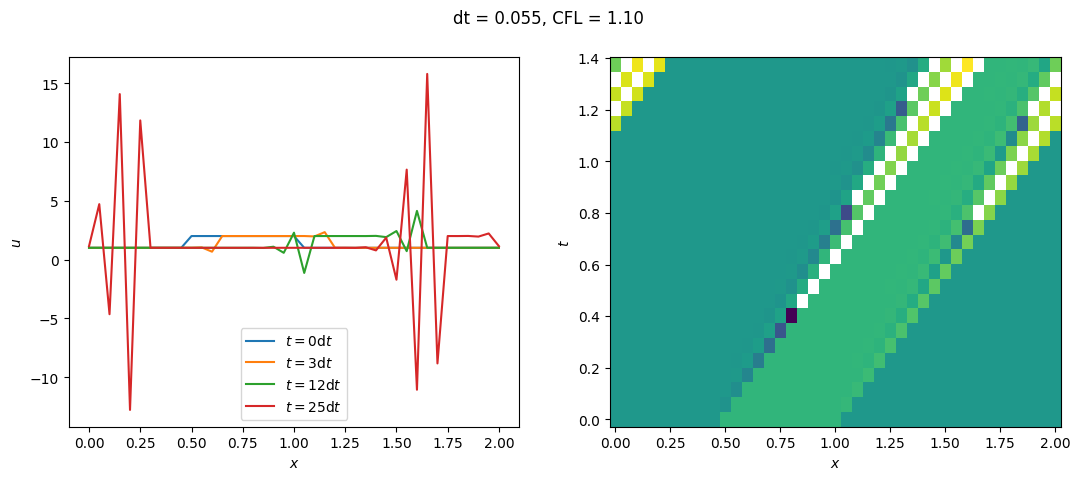

In [13]:
dt = 0.055 # change dt to vary CFL
Delta_T = nt * dt # compensate by increasing Delta_T to keep the total number of data points the same
T = np.linspace(0, Delta_T, nt) # new time grid

U = evolve(u0)
make_plot()

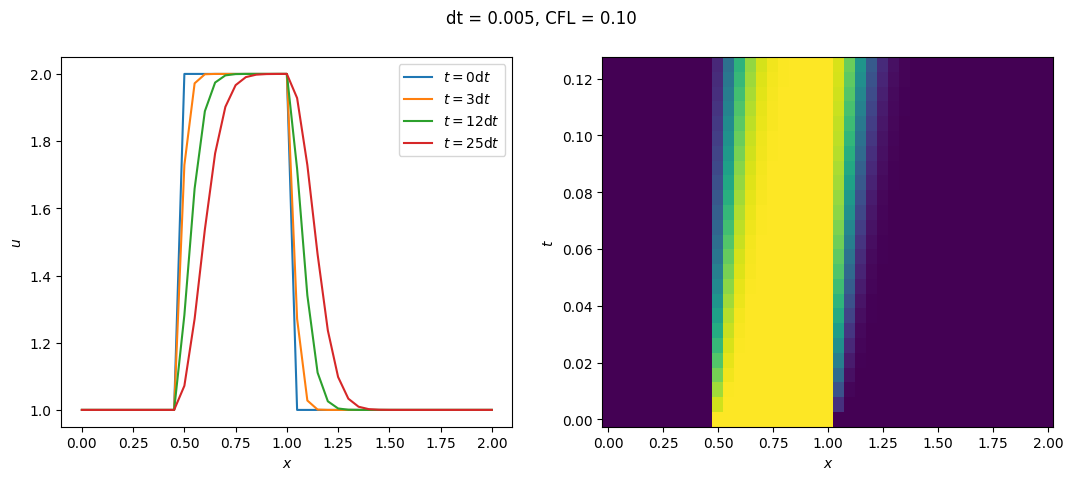

In [14]:
dt = 0.005
Delta_T = nt * dt
T = np.linspace(0, Delta_T, nt)

U = evolve(u0)
make_plot()

C:\Users\okwas\AppData\Local\Temp\ipykernel_49156\180672108.py:10: RuntimeWarning: invalid value encountered in log
  ax2.pcolormesh(X, T, np.log(U[:-1, :]), shading='nearest') # log u(x, t)


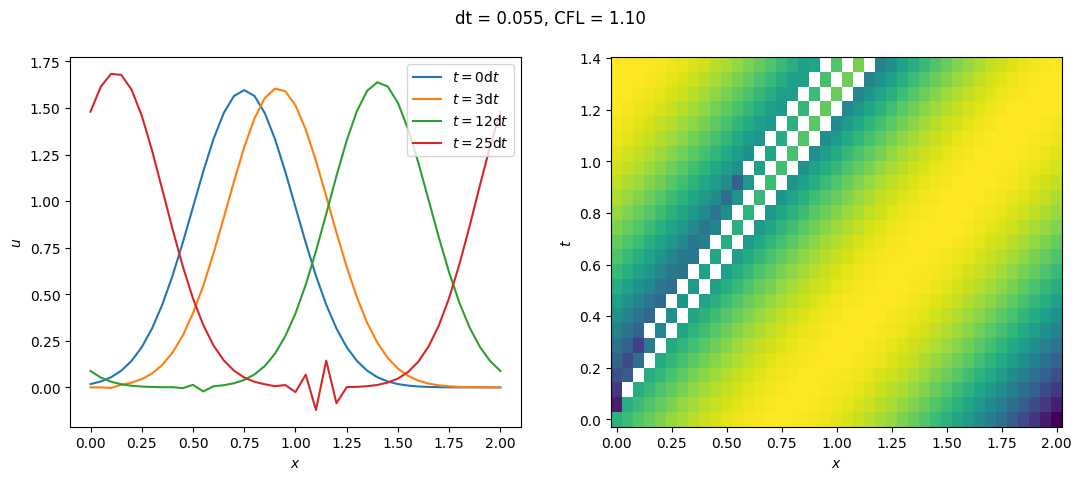

In [15]:
dt = 0.055
Delta_T = nt * dt
T = np.linspace(0, Delta_T, nt)

u0_gauss = np.array([gauss(x, 0.75, 0.25) for x in X])
U = evolve(u0_gauss)
make_plot()

 Redo the same thing using a 2nd order accuracy expression for the space derivative, and 1st order accuracy expression for the time derivative
    like leap frog.

What is the new integration scheme?

$$\begin{align}
&\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} \approx \frac{U^{n+1}_i - U^{n}_i}{\text{d}t} + c \frac{U^n_{i+1} - U^n_{i-1}}{2\text{d}x} = 0\\
\therefore{} &U^{n+1}_i = U^n_i - \frac{1}{2} \frac{c\; \text{dt}}{\text{dx}} (U^n_{i+1} - U^n_{i-1}) = U^n_i + \frac{\sigma}{2} (U^n_{i-1} - U^n_{i+1})
\end{align}$$

Write your new code and do a try with CFL=0.5

C:\Users\okwas\AppData\Local\Temp\ipykernel_49156\180672108.py:10: RuntimeWarning: invalid value encountered in log
  ax2.pcolormesh(X, T, np.log(U[:-1, :]), shading='nearest') # log u(x, t)


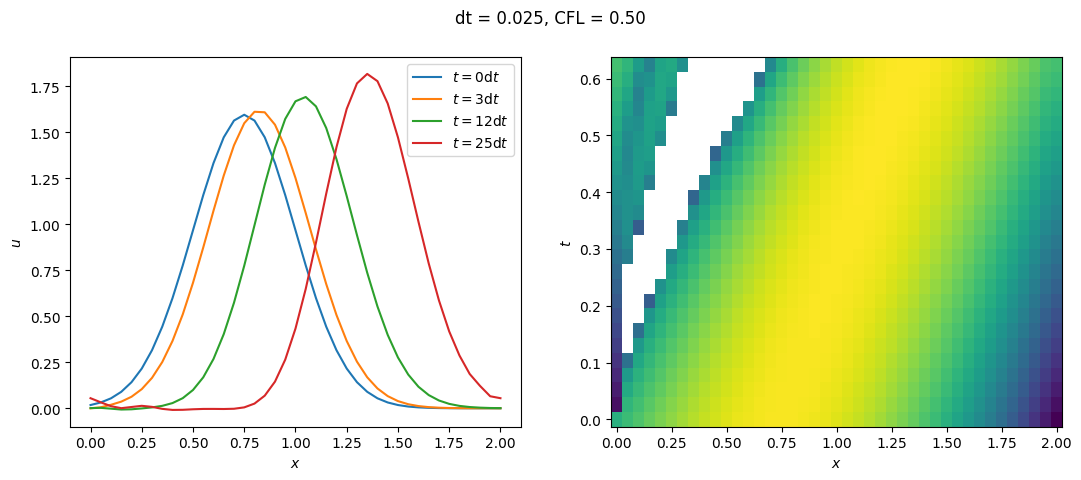

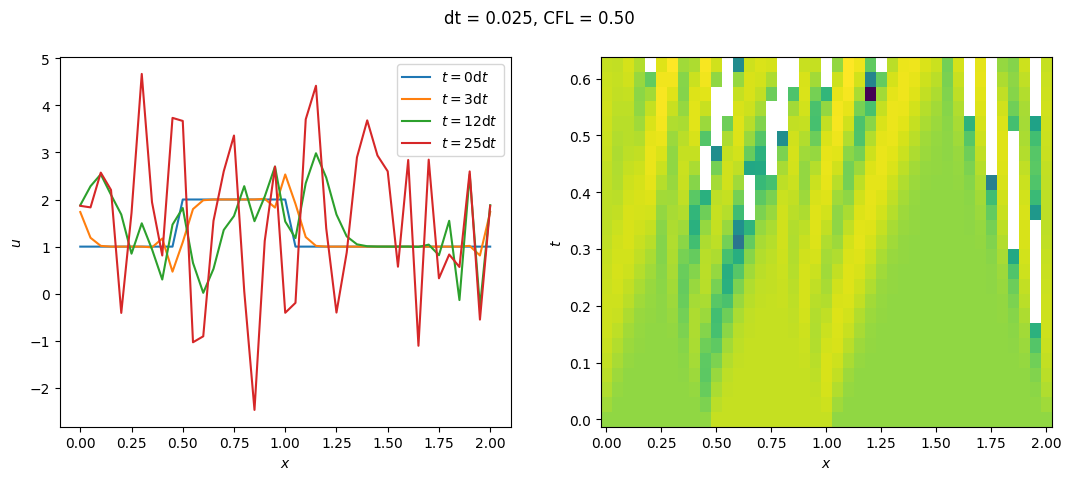

In [16]:
def leap_1t2s(u):
    '''Single time step of the leapfrog scheme '''
    sigma = get_cfl()

    diag_1 = np.diag(np.full(nx-1, -sigma/2), k=+1) # - sigma/2 above the diagonal
    diag_2 = np.diag(np.full(nx-1, sigma/2), k=-1) # + sigma/2 below the diagonal
    M = diag_1 + diag_2 # full bidiagonal matrix
    
    u = u + np.matmul(M, u) # U(n+1) = U(n-1) + M U(n)
    u[0] = u[-1]

    return u

def leap_1t2s_evolve(u0):
    '''Evolve the waveform using the leapfrog scheme (1st order in time, 2nd order in space)'''
    U = np.array(u0, ndmin=2) # create a 2D array, rows are times, columns are positions
    u = U[-1] # current waveform

    for t in T:
        u = leap_1t2s(u) # apply the leapfrog scheme
        U = np.vstack((U, u)) # append the results

    return U

dt = 0.025
Delta_T = nt * dt
T = np.linspace(0, Delta_T, nt)

U = leap_1t2s_evolve(u0_gauss)
make_plot()

U = leap_1t2s_evolve(u0)
make_plot()

Comment ?

It seems to work much worse than the upwind scheming, narrowing the gaussian and breaking down very quickly in the top hat case. The version which is 2nd order in both time and space (described below) seems to work much better.

# Extra - Leapfrog of 2nd order in both time and space, using matrix from the lecture slides

C:\Users\okwas\AppData\Local\Temp\ipykernel_49156\180672108.py:10: RuntimeWarning: invalid value encountered in log
  ax2.pcolormesh(X, T, np.log(U[:-1, :]), shading='nearest') # log u(x, t)


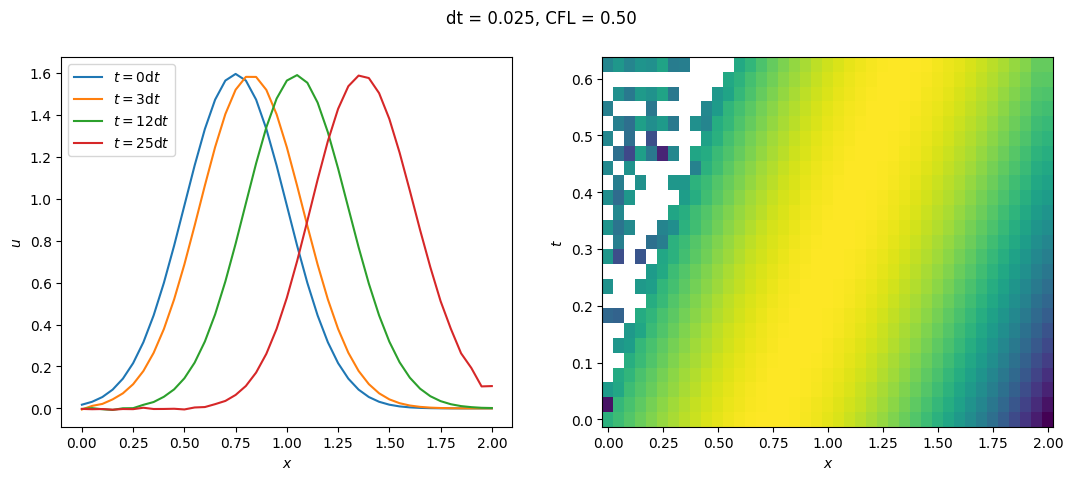

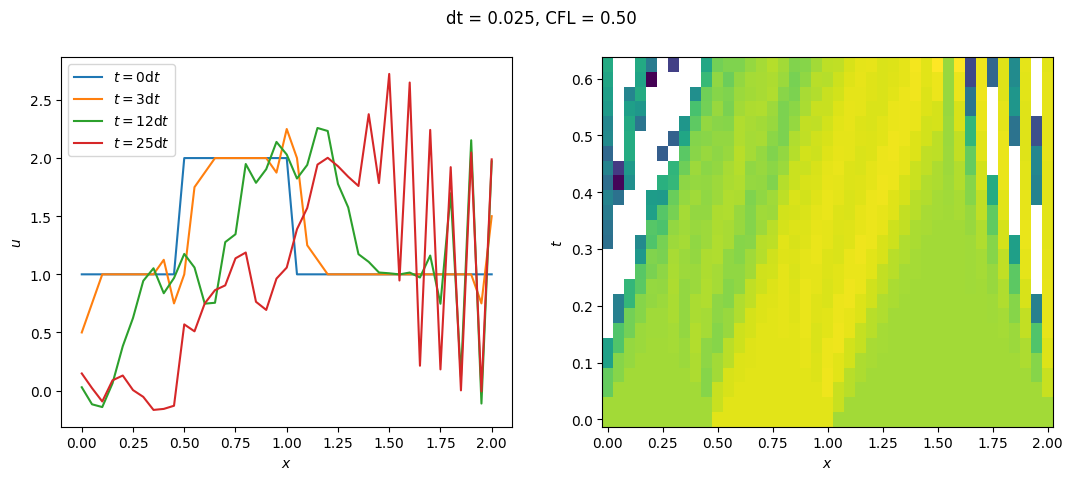

In [17]:
def leap_2t2s(u, u_prev):
    '''Single time step of the leapfrog scheme (2nd order in both time and space)'''
    sigma = get_cfl()

    diag_1 = np.diag(np.full(nx-1, -sigma), k=+1) # - sigma above the diagonal
    diag_2 = np.diag(np.full(nx-1, sigma), k=-1) # + sigma below the diagonal
    M = diag_1 + diag_2 # full bidiagonal matrix
    
    u = u_prev + np.matmul(M, u) # U(n+1) = U(n-1) + M U(n)

    return u

def leap_2t2s_evolve(u0):
    '''Evolve the waveform using leapfrog (2nd order in both time and space)'''
    u1 = step(u0) # evolve the initial waveform once using upwind
    U = np.vstack((u0, u1)) # append the results
    u = U[-1]

    for t in T[1:]: # start leapfrog from the 2nd time step
        u_prev = U[-2] # define the waveform at the previous time step
        u = leap_2t2s(u, u_prev) # apply leapfrog
        U = np.vstack((U, u)) # append the leapfrogged waveform

    return U

dt = 0.025
Delta_T = nt * dt
T = np.linspace(0, Delta_T, nt)

U = leap_2t2s_evolve(u0_gauss)
make_plot()

U = leap_2t2s_evolve(u0)
make_plot()

While some artifacts are visible at the edges of the gaussian, its keeps its overall shape much better than in the upwind scheme - its height and width stay roughly the same, with no visible spreading. In general, this implementation of the leapfrog scheme only performs better for shapes with no sharp edges / discountinuities, as seen in the top hat case, where it breaks completely. 